# Introduction

The datasets contains transactions made by credit cards in September 2013 by european cardholders. This dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions.

It contains only numerical input variables which are the result of a PCA transformation. Unfortunately, due to confidentiality issues, we cannot provide the original features and more background information about the data. Features V1, V2, ... V28 are the principal components obtained with PCA, the only features which have not been transformed with PCA are 'Time' and 'Amount'. Feature 'Time' contains the seconds elapsed between each transaction and the first transaction in the dataset. The feature 'Amount' is the transaction Amount, this feature can be used for example-dependant cost-senstive learning. Feature 'Class' is the response variable and it takes value 1 in case of fraud and 0 otherwise.

Source: https://www.kaggle.com/mlg-ulb/creditcardfraud

## Pre-Processing

In [129]:
#import standard packages
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

#import graphing packages
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from tabulate import tabulate

#import modeling packages
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE

#import feature and hyperparameter tuning packages
from sklearn.feature_selection import RFE
from sklearn.model_selection import RandomizedSearchCV

#import stats packages
from scipy import stats
from scipy.stats import uniform
from sklearn import metrics

#import scoring packages
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve



#read csv to df
df =pd.read_csv('creditcard.csv')

#assing column name to col_names and print 
col_names =df.columns.tolist()
print("Column names:")
print(col_names)

#preview first 5 rows of data
print("\nSample data:")
df.head()


Column names:
['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount', 'Class']

Sample data:


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [130]:
#get shape(size) of dataset
df.shape

(284807, 31)

The data has 284807 rows and 31 columns(features)

In [131]:
#check types of data 
df.dtypes

Time      float64
V1        float64
V2        float64
V3        float64
V4        float64
V5        float64
V6        float64
V7        float64
V8        float64
V9        float64
V10       float64
V11       float64
V12       float64
V13       float64
V14       float64
V15       float64
V16       float64
V17       float64
V18       float64
V19       float64
V20       float64
V21       float64
V22       float64
V23       float64
V24       float64
V25       float64
V26       float64
V27       float64
V28       float64
Amount    float64
Class       int64
dtype: object

All of the data is typed float64 except the outcome which is type int. 

In [132]:
#check for missing data
df.isnull().sum()

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

No datapoints missing from the set.

## Data Exploration

In [133]:
#get counts of rows in the outcome column (Class)
print(df['Class'].value_counts())

#assign array of class datapoints to y
y = np.array(df.Class.tolist())

#print % of Fraud and not Fraud
print("% of frauds: {:.5f}".format((np.sum(y)/len(y))*100))


0    284315
1       492
Name: Class, dtype: int64
% of frauds: 0.17275


Large class imbalance between not-fraud(0) and fraud(1). The other columns have been transformed with PCA and the feature names have been removed for privacy reasons.

In [134]:
# return mean amount seperated by Not Fraud(0) and Fraud(1)
df.groupby('Class')['Amount'].mean()

Class
0     88.291022
1    122.211321
Name: Amount, dtype: float64

Average purchase price for fradulent data is slightly higher than for non-fraud purchases.

In [135]:
#Describe dataset
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,3.919560e-15,5.688174e-16,-8.769071e-15,2.782312e-15,-1.552563e-15,2.010663e-15,-1.694249e-15,-1.927028e-16,-3.137024e-15,...,1.537294e-16,7.959909e-16,5.367590e-16,4.458112e-15,1.453003e-15,1.699104e-15,-3.660161e-16,-1.206049e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


Time 0.0  not normal
V1 0.0  not normal
V2 0.0  not normal
V3 0.0  not normal
V4 0.0  not normal
V5 0.0  not normal
V6 0.0  not normal
V7 0.0  not normal
V8 0.0  not normal
V9 0.0  not normal
V10 0.0  not normal
V11 0.0  not normal
V12 0.0  not normal
V13 2.4199736295e-126  not normal
V14 0.0  not normal
V15 0.0  not normal
V16 0.0  not normal
V17 0.0  not normal
V18 0.0  not normal
V19 0.0  not normal
V20 0.0  not normal
V21 0.0  not normal
V22 0.0  not normal
V23 0.0  not normal
V24 0.0  not normal
V25 0.0  not normal
V26 0.0  not normal
V27 0.0  not normal
V28 0.0  not normal
Amount 0.0  not normal


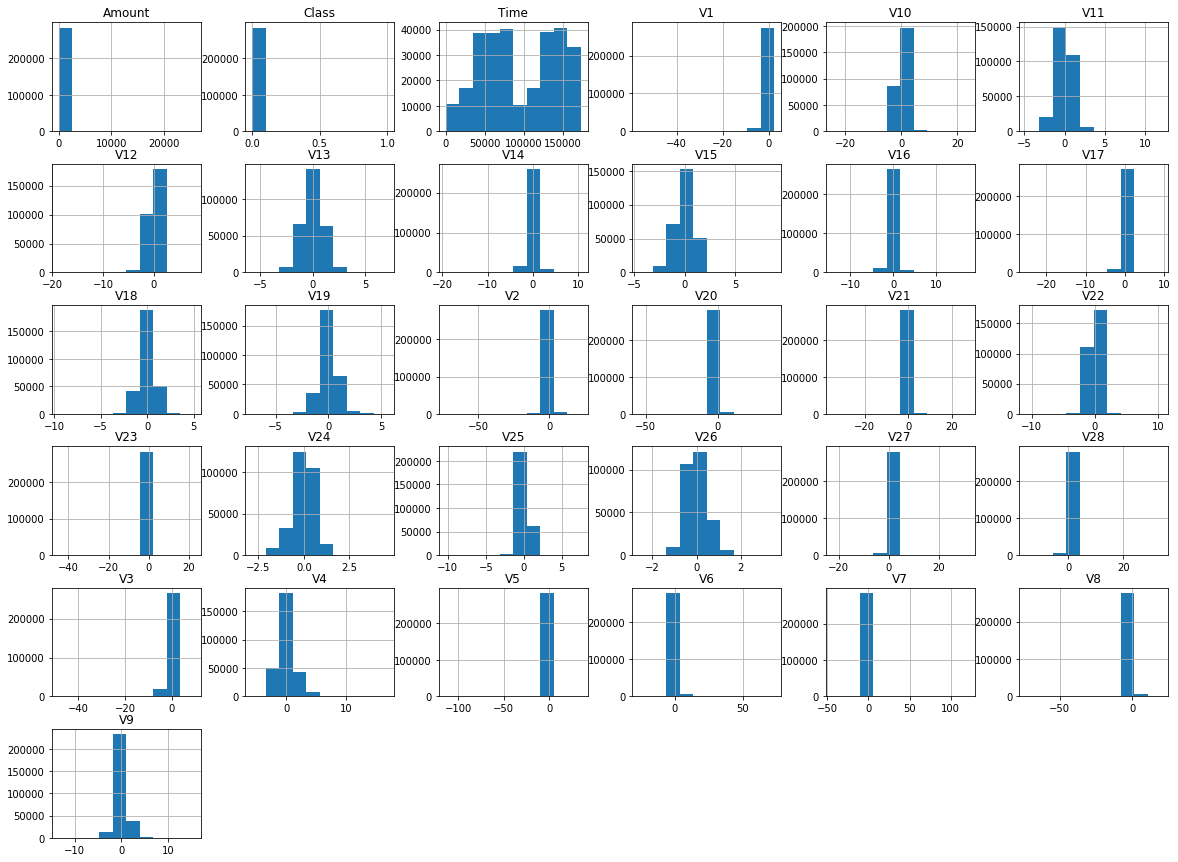

In [136]:
for col in df.columns.drop(['Class']): #initialize loop dropping outcome and object types cols
    _,pval = stats.normaltest(df[col]) 
    if pval > .05:
        print(col, pval)
    else:
        print(col, pval, " not normal")

#assing parameters to histogram
num_bins = 10
df.hist(bins=num_bins, figsize=(20,15))

#plot graphs
plt.show()

None of our features have a normal distribution. There is no obvious skew to the data.

In [137]:
#seperate dataframes by outcome
nf = df[df['Class'] == 0]
f = df[df['Class'] == 1]

#run mannwhitneyu and #ttest
for col in nf.columns.drop(['Class']):
 
     _,val = stats.mannwhitneyu(nf[col], f[col])
     if val < .05:
        continue
     elif val > .05:
        print('MW : ',col, pval)
        
     _,pval = stats.ttest_ind(nf[col], f[col])
     if pval < .05:
        continue
     else:
        print('pv : ',col, val)

MW :  V15 0.0
MW :  V22 0.0242014260015
pv :  V22 0.133197325012


V22 and V15 have p and u values above .05, so I can't conclude a signficant difference exists between the data. I have a large number of features, so I'll drop these 2.

In [138]:
df.drop(['V22', 'V15'], axis=1, inplace = True)

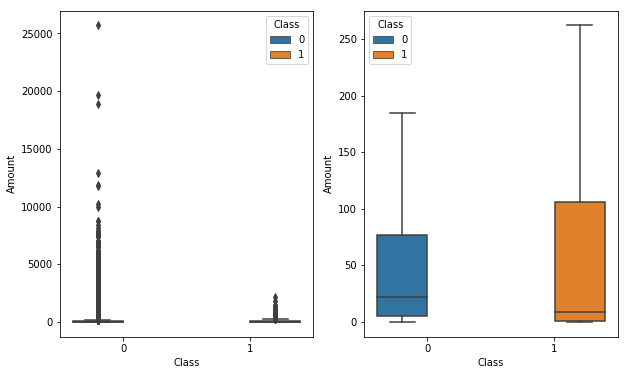

In [139]:
# create axis and size of plots
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10,6))

#assign parameters of boxplots to var s
s = sns.boxplot(ax = ax1, x ="Class", y = "Amount",
                hue = "Class", data = df, showfliers=True)
s = sns.boxplot(ax = ax2, x ="Class", y = "Amount",
                hue = "Class", data = df, showfliers=False)

#Plot graphs
plt.show()






The mean amount for fradulent transactions is slightly higher. Non-fradulent transactions have more outliers, which is expected becuase it has 200,000 more data points.

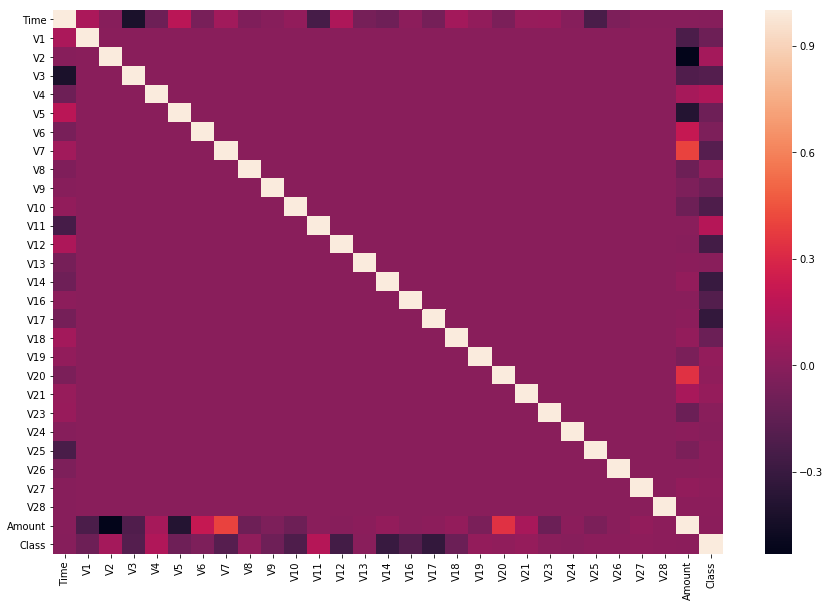

In [140]:
#initiate subplots and assign fig size
plt.subplots(figsize=(15,10))

#plot correlation matrix
sns.heatmap(df.corr())


All of the correlations are very close to zero. Amount has a higher correlation with V7 and V20, but not with each other or with the outcome. I'll use RFE below to hopefully narrow down the features. Also, I know nothing about the features, so I can't reduce them in a logical way based on knowledge of credit card fraud.

## Build Train Tune Models

## Up/Down Sampling and Logistic Regression

I'll seperate the outcome(y) from the dataset(X) 

In [141]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegressionCV
#instantiate and fit LR model
model = LogisticRegressionCV()
rfe = RFE(model,27, verbose =1)
rfe = rfe.fit(df.drop('Class', axis=1), df['Class'])

#assign rankings to column_num variable and print
column_num = rfe.ranking_
print(rfe.support_)
print(rfe.ranking_)



Fitting estimator with 28 features.
[False  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True]
[2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


I can only reduce my features by 1 without affecting the accuracy of my model. 

In [142]:
#Turn the ranking above into a list and cut out features that aren't scored '1'

#assign cols to an empty list
cols = []
#create a for loop that enumerates indexes and values
for idx, val in enumerate(column_num):
    if val == 1:
        cols.append(idx)
        
#use cols list to create new array of the features I want to keep
X_slim=df.iloc[:, cols]




In [198]:
from sklearn.model_selection import train_test_split
#set train size to 80% train 20% test
X_train, X_test, y_train, y_test = train_test_split(X_slim, df['Class'],
                                                    test_size =0.20,
                                                    random_state = 123)
from imblearn.over_sampling import SMOTE
# instantiate and fit SMOTE (upsampling)
sm = SMOTE(random_state =12, ratio = 1.0)
X_train_up, y_train_up = sm.fit_sample(X_train, y_train)

Created a training and test set with an 80/20 split, and upsampled the training set only using SMOTE. 

In [199]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
#instantiate and fit LR model
lr = LogisticRegression()
lr.fit(X_train_up, y_train_up)

#print results of model tested on train set
print(lr.score(X_train_up, y_train_up))
lr.get_params()

0.958231487506


{'C': 1.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'max_iter': 100,
 'multi_class': 'ovr',
 'n_jobs': 1,
 'penalty': 'l2',
 'random_state': None,
 'solver': 'liblinear',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

My first model with upsampling is pretty good, predicting 96.2% of the data. We'll see if undersampling performs better.

In [200]:
#Under sampling 
from imblearn.under_sampling import RandomUnderSampler

runs = RandomUnderSampler()
X_runs, y_runs = runs.fit_sample(X=X_train, y=y_train)

In [201]:
#print results of model tested on train set
print(lr.score(X_runs, y_runs))
lr.get_params()

0.941644562334


{'C': 1.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'max_iter': 100,
 'multi_class': 'ovr',
 'n_jobs': 1,
 'penalty': 'l2',
 'random_state': None,
 'solver': 'liblinear',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

My model with undersampled data performs slightly worse, predicting 94.8% of the data; However, my dataset is rather large, so we'll use down sampling for this exercise. We'll take a look at the coefficients for this first model.

In [202]:
print(lr.coef_)
print(lr.intercept_)


[[ 0.5705336  -0.01408131  0.1462082   1.01213979  0.50957421 -0.2551072
  -0.10723751 -0.6478551  -0.43802634 -0.80762708  0.61126218 -1.24894145
  -0.19053396 -1.50614729 -0.79862167 -1.10314107 -0.43073793  0.06044457
  -0.39346015  0.16012546  0.04163945 -0.11710581 -0.01463426  0.00158973
   0.53830967  0.66126467  0.00234139]]
[-4.09775278]


We'll tune all three models with Randomized Search.

In [203]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform
from sklearn.linear_model import LogisticRegression

# Create logistic regression
logistic = LogisticRegression()

# Create regularization penalty
#penalty = ['l1', 'l2']

# Create regularization hyperparameter distribution using uniform distribution
C = uniform(loc=0, scale=4)

#create solver hyperparameter
solver = ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']

# Create hyperparameter options
hyperparameters = dict(C=C, solver = solver)

# Create randomized search 3-fold cross validation and 100 iterations. Add verbosity for runtime
clf = RandomizedSearchCV(logistic, hyperparameters, random_state=123, n_iter=100, cv=3,n_jobs=-1, verbose=1)

# Fit randomized search
best_model = clf.fit(X_runs, y_runs)

# View best hyperparameters 
print('Best Penalty:', best_model.best_estimator_.get_params()['penalty'])
print('Best C:', best_model.best_estimator_.get_params()['C'])
print('Best solver:', best_model.best_estimator_.get_params()['solver'])

Fitting 3 folds for each of 100 candidates, totalling 300 fits
Best Penalty: l2
Best C: 0.172107627741
Best solver: newton-cg


[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    2.3s finished


In [204]:
lr1 = LogisticRegression(C = 0.172107627741,
                         penalty = 'l2',
                         solver = 'liblinear',
                         verbose =1 )
lr1.fit(X_train_up, y_train_up)
#print results of model tested on train set
print(lr1.score(X_train_up, y_train_up))
lr1.get_params()

[LibLinear]0.958198515835


{'C': 0.172107627741,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'max_iter': 100,
 'multi_class': 'ovr',
 'n_jobs': 1,
 'penalty': 'l2',
 'random_state': None,
 'solver': 'liblinear',
 'tol': 0.0001,
 'verbose': 1,
 'warm_start': False}

Our first model performs about the same as the original model.

In [206]:
#Create regularization penalty
penalty = ['l1', 'l2']

# Create regularization hyperparameter distribution using uniform distribution
C = uniform(loc=0, scale=4)

#create solver hyperparameter
solver = ['liblinear', 'saga']

# Create hyperparameter options
hyperparameters = dict(C=C, solver = solver, penalty = penalty)

# Create randomized search 3-fold cross validation and 100 iterations. Add verbosity for runtime
clf = RandomizedSearchCV(logistic, hyperparameters, random_state=1, n_iter=100, cv=3, n_jobs=-1, verbose=1)

# Fit randomized search
best_model = clf.fit(X_runs, y_runs)

# View best hyperparameters 
print('Best Penalty:', best_model.best_estimator_.get_params()['penalty'])
print('Best C:', best_model.best_estimator_.get_params()['C'])
print('Best C:', best_model.best_estimator_.get_params()['solver'])

Fitting 3 folds for each of 100 candidates, totalling 300 fits
Best Penalty: l1
Best C: 0.239670758049
Best C: liblinear


[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    2.1s finished


In [207]:
lr2 = LogisticRegression(C = 0.239670758049,
                        solver = 'liblinear',
                        penalty = 'l2')
lr2.fit(X_runs, y_runs)

#print results of model tested on train set
print(lr2.score(X_runs, y_runs))
lr2.get_params()

0.949602122016


{'C': 0.239670758049,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'max_iter': 100,
 'multi_class': 'ovr',
 'n_jobs': 1,
 'penalty': 'l2',
 'random_state': None,
 'solver': 'liblinear',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

Our second model performs worse tahn the previous two. We'll check the confusion matrixes for the three models below.

             precision    recall  f1-score   support

          0       0.91      0.98      0.94       377
          1       0.98      0.90      0.94       377

avg / total       0.94      0.94      0.94       754



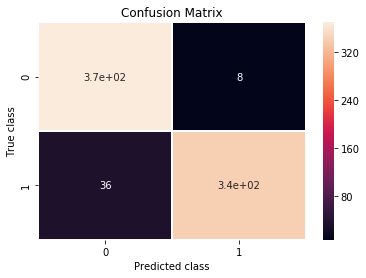

In [211]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
import seaborn as sns

def conf(model,x,y):
    y_pred = model.predict(x)
    logreg_cm = confusion_matrix(y, y_pred)
    sns.heatmap(logreg_cm,
            annot=True,
            linewidths=0.5,)
    plt.ylabel('True class')
    plt.xlabel('Predicted class')
    plt.title('Confusion Matrix')
    plt.savefig('Confusion Matrix')

    from sklearn.metrics import classification_report
    print(classification_report(y, model.predict(x)))
conf(lr,X_runs, y_runs)


             precision    recall  f1-score   support

          0       0.91      0.98      0.94       377
          1       0.98      0.90      0.94       377

avg / total       0.94      0.94      0.94       754



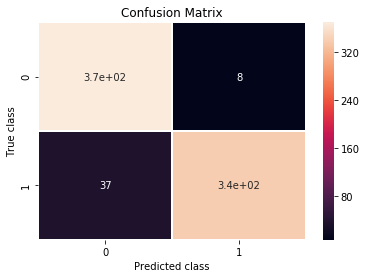

In [212]:
conf(lr1,X_runs, y_runs)

             precision    recall  f1-score   support

          0       0.93      0.97      0.95       377
          1       0.97      0.93      0.95       377

avg / total       0.95      0.95      0.95       754



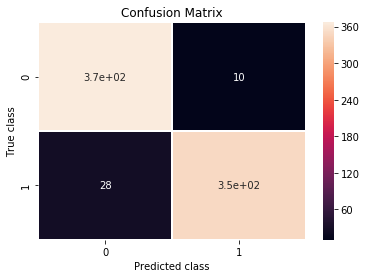

In [213]:
conf(lr2,X_runs, y_runs)

The 3rd model (lr2) performs the best in recall and f-1 for our fradulant outcome. We'll stick with that as our model. The small difference in C in our model makes a noticeable difference in recall. On to SVC.

## SVC 
For our SVC model, we'll still use the undersampled training data.

In [248]:
from sklearn.svm import SVC
svc = SVC(verbose =1)
svc.fit(X_runs, y_runs)
print(svc.score(X_runs, y_runs))
svc.get_params()

[LibSVM]0.986737400531


{'C': 1.0,
 'cache_size': 200,
 'class_weight': None,
 'coef0': 0.0,
 'decision_function_shape': 'ovr',
 'degree': 3,
 'gamma': 'auto',
 'kernel': 'rbf',
 'max_iter': -1,
 'probability': False,
 'random_state': None,
 'shrinking': True,
 'tol': 0.001,
 'verbose': 1}

The accuracy for the vanilla SVC model is very high at 98%.

In [227]:
# Create regularization hyperparameter distribution using uniform distribution
C = uniform(loc=0, scale=4)

# Create gamma hyperparameter
gamma = np.arange(0.1, 1, 0.2)

#create kernel hyperparameter
kernel = [ 'linear', 'poly', 'rbf', 'sigmoid' ]

# Create hyperparameter options
hyperparameters = dict(C=C, kernel = kernel, gamma = gamma)

# Create randomized search 2-fold cross validation and 50 iterations. Add verbosity for runtime
clf = RandomizedSearchCV(svc, hyperparameters, random_state=1, n_iter=50, cv=2,n_jobs =-1, verbose=1)

# Fit randomized search
best_model = clf.fit(X_runs, y_runs)

# View best hyperparameters 
print('Best kernel:', best_model.best_estimator_.get_params()['kernel'])
print('Best C:', best_model.best_estimator_.get_params()['C'])
print('Best gamma:', best_model.best_estimator_.get_params()['gamma'])
print(clf.best_score_)

Fitting 2 folds for each of 50 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 11.1min finished


[LibSVM]Best kernel: linear
Best C: 0.5684805419
Best gamma: 0.5
0.924403183024


In [252]:
#instantiate and fit model with best parameters from above RandomizedSearch 
svc1 = SVC(kernel='linear', 
          C=0.5684805419,
          gamma =0.5, 
          verbose =1)
svc1.fit(X_runs, y_runs)
print(svc1.score(X_runs, y_runs))

[LibSVM]0.949602122016


             precision    recall  f1-score   support

          0       0.97      1.00      0.99       377
          1       1.00      0.97      0.99       377

avg / total       0.99      0.99      0.99       754



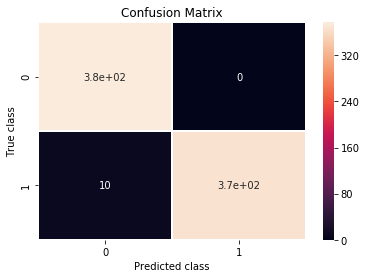

In [250]:
conf(svc,X_runs, y_runs)

             precision    recall  f1-score   support

          0       0.93      0.97      0.95       377
          1       0.97      0.93      0.95       377

avg / total       0.95      0.95      0.95       754



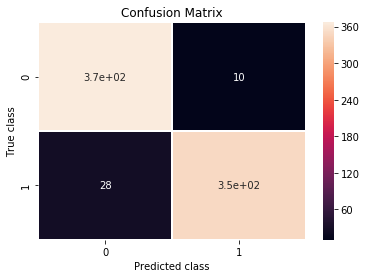

In [251]:
conf(svc1,X_runs, y_runs)

Our Vanilla SVC model performs better than the tuned model. We'll stick with that below. Next is Random Forest. 

## Random Forest
We'll test and tune the random forest model with the original training set data, no downsampling.

In [256]:
from sklearn.ensemble import RandomForestClassifier

#instantiate and fit model with best parameters from above RandomSearch 
rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)
print(rfc.score(X_train, y_train))
rfc.get_params()

0.999899054182


{'bootstrap': True,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 10,
 'n_jobs': 1,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

As it usually does, Random Forest performs the best out of the box. We'll tune below just to be consistent.

In [229]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier() 

# Create hyperparamater values
n_estimators = np.arange(1,100,5)
max_depth = np.arange(1, 30, 5)
min_samples_leaf = np.arange(1, 10, 1)

# Create hyperparameter options
hyperparameters = dict(n_estimators=n_estimators,
                       max_depth = max_depth,
                       min_samples_leaf = min_samples_leaf)

# Create randomized search 2-fold cross validation and 50 iterations. Add verbosity for runtime
clf = RandomizedSearchCV(rfc, hyperparameters, random_state=1, n_iter=50, cv=2, verbose=1)
# Fit randomized search
best_model = clf.fit(X_train, y_train)

# View best hyperparameters 
print('Best n_estimators:', best_model.best_estimator_.get_params()['n_estimators'])
print('Best max_depth:', best_model.best_estimator_.get_params()['max_depth'])
print('Best min_samples_leaf:', best_model.best_estimator_.get_params()['min_samples_leaf'])
print(clf.best_score_)

Fitting 2 folds for each of 50 candidates, totalling 100 fits


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed: 36.2min finished


Best n_estimators: 71
Best max_depth: 16
Best min_samples_leaf: 1
0.999482104062


In [257]:
rfc1 = RandomForestClassifier(n_estimators=71,
                       max_depth = 16,
                       min_samples_leaf = 1)
rfc1.fit(X_train, y_train)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=16, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=71, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

             precision    recall  f1-score   support

          0       1.00      1.00      1.00    227468
          1       1.00      0.94      0.97       377

avg / total       1.00      1.00      1.00    227845



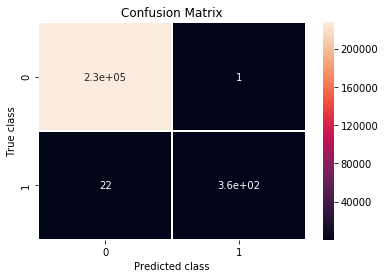

In [258]:
conf(rfc,X_train, y_train)

             precision    recall  f1-score   support

          0       1.00      1.00      1.00    227468
          1       1.00      0.87      0.93       377

avg / total       1.00      1.00      1.00    227845



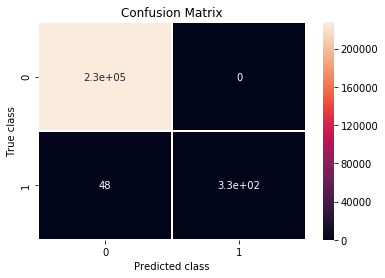

In [259]:
conf(rfc1,X_train, y_train)

Our vanilla model performs better than the tuned model. On to testing.

## Comparing models on test data

### Logistic Regression

             precision    recall  f1-score   support

          0       1.00      0.96      0.98     56847
          1       0.04      0.93      0.08       115

avg / total       1.00      0.96      0.98     56962



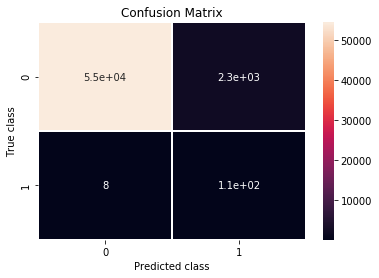

In [260]:
conf(lr2,X_test, y_test)

### Random Forest

             precision    recall  f1-score   support

          0       1.00      1.00      1.00     56847
          1       0.93      0.79      0.85       115

avg / total       1.00      1.00      1.00     56962



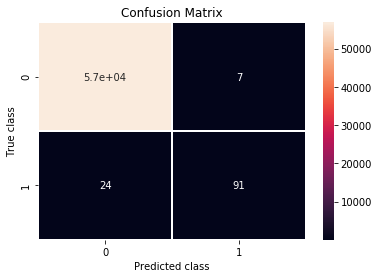

In [261]:
conf(rfc,X_test,y_test)

### SVC

             precision    recall  f1-score   support

          0       1.00      0.85      0.92     56847
          1       0.01      0.96      0.02       115

avg / total       1.00      0.85      0.92     56962



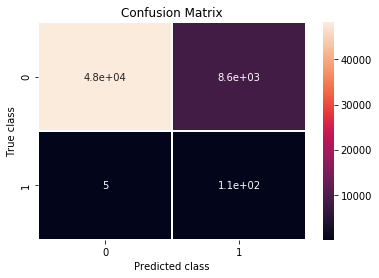

In [262]:
conf(svc,X_test,y_test)

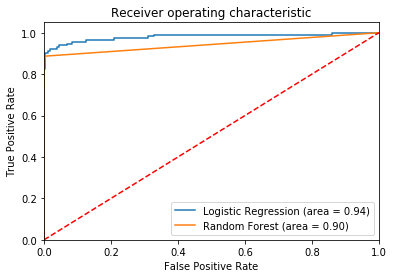

In [264]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
logit_roc_auc = roc_auc_score(y_test, lr2.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, lr2.predict_proba(X_test)[:,1])
rf_roc_auc = roc_auc_score(y_test, rfc.predict(X_test))
rf_fpr, rf_tpr, rf_thresholds = roc_curve(y_test, rfc.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot(rf_fpr, rf_tpr, label='Random Forest (area = %0.2f)' % rf_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('ROC')
plt.show()

This is a bit of a mixed bag.

SVC has the least amount of type 2 errors, but misses horribly on predicting fraud. It has a very low f-1 score for fraudulant cases.

This comes down to Random Forest and Logistic Regression.

Random Forest is by far more accurate, but it produces 3 times as many false negatives (missed cases of fraud) compared to Logistic Regression. On the other hand, LR produces ~30x more false positives as Random Forest. 

The area under the receiver operatic characteristic curve is slightly higher for LR, Logistic Regression is much quicker to run, and it avoids false negatives better than a Random Forest model. I would probably pick Logistic Regression with undersampling and tuning for predicting fraud.


